In [10]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [11]:
img_size = (128, 128)
batch_size = 32

In [12]:
import os
import shutil
import random


output_path = "/kaggle/input/oral-dataset-split/oral_dataset_split"  # Use /kaggle/working/ to store the split data




In [15]:
for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_path, split)
    print(f"{split} set:")
    for class_name in os.listdir(split_path):
        print(f"  {class_name}: {len(os.listdir(os.path.join(split_path, class_name)))} images")


train set:
  ulcers: 1778 images
  caries: 1667 images
  hypodontia: 875 images
  gingivitis: 1644 images
  toothDiscoloration: 1283 images
  calculus: 907 images
val set:
  ulcers: 381 images
  caries: 357 images
  hypodontia: 187 images
  gingivitis: 352 images
  toothDiscoloration: 275 images
  calculus: 194 images
test set:
  ulcers: 382 images
  caries: 358 images
  hypodontia: 189 images
  gingivitis: 353 images
  toothDiscoloration: 276 images
  calculus: 195 images


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
train_dir = "/kaggle/input/oral-dataset-split/oral_dataset_split/train"
val_dir = "/kaggle/input/oral-dataset-split/oral_dataset_split/val"
test_dir = "/kaggle/input/oral-dataset-split/oral_dataset_split/test"

# Define ImageDataGenerator for training (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,           # Normalize pixel values
    rotation_range=30,         # Rotate images randomly
    width_shift_range=0.2,     # Shift images horizontally
    height_shift_range=0.2,    # Shift images vertically
    zoom_range=0.2,            # Zoom in/out
    horizontal_flip=True,      # Flip horizontally
    fill_mode="nearest"        # Fill missing pixels
)

# For validation & testing, we only rescale (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),    # Resize images to match input shape
    batch_size=32,
    class_mode="categorical"   # Since it's a multi-class problem
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Important for evaluation
)

print("Data augmentation applied successfully! 🚀")


Found 8154 images belonging to 6 classes.
Found 1746 images belonging to 6 classes.
Found 1753 images belonging to 6 classes.
Data augmentation applied successfully! 🚀


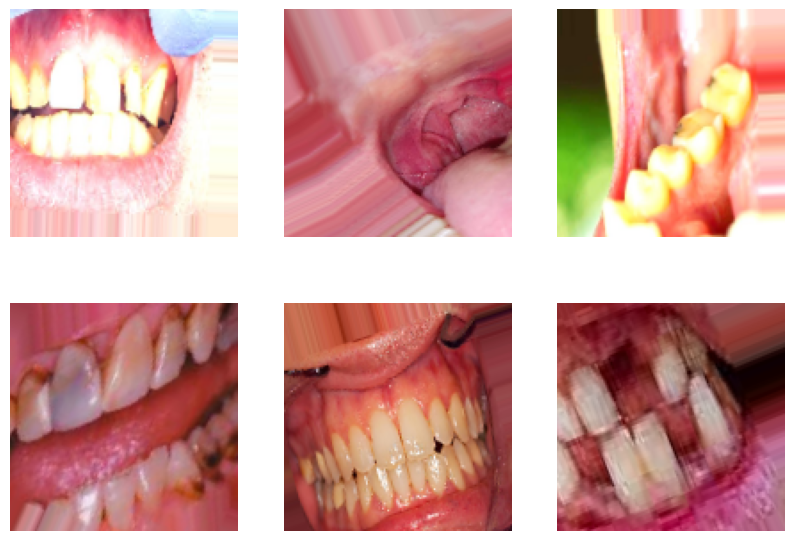

In [17]:
import matplotlib.pyplot as plt

# Get a batch of images
batch_images, batch_labels = next(train_generator)

# Plot 6 images
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(batch_images[i])
    ax.axis("off")
plt.show()


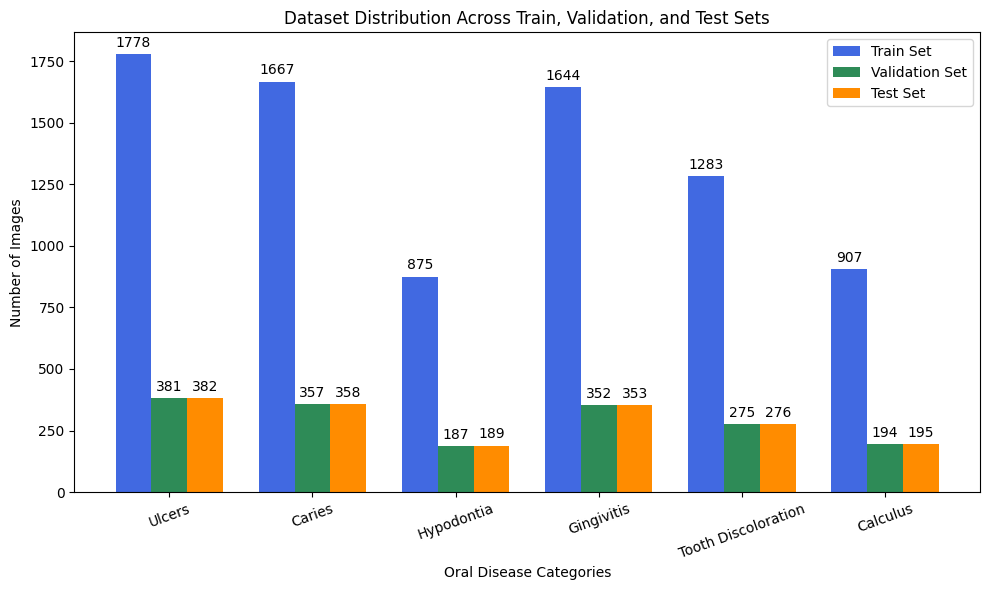

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ["Ulcers", "Caries", "Hypodontia", "Gingivitis", "Tooth Discoloration", "Calculus"]
train_counts = [1778, 1667, 875, 1644, 1283, 907]
val_counts = [381, 357, 187, 352, 275, 194]
test_counts = [382, 358, 189, 353, 276, 195]

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
rects1 = ax.bar(x - width, train_counts, width, label="Train Set", color="royalblue")
rects2 = ax.bar(x, val_counts, width, label="Validation Set", color="seagreen")
rects3 = ax.bar(x + width, test_counts, width, label="Test Set", color="darkorange")

# Labels, title, and legend
ax.set_xlabel("Oral Disease Categories")
ax.set_ylabel("Number of Images")
ax.set_title("Dataset Distribution Across Train, Validation, and Test Sets")
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=20)
ax.legend()

# Show values on top of bars
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f"{height}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# For calculating Precision and other

In [23]:
from tensorflow.keras import backend as K
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# 1. ResNet50

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Choose ResNet model
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))  # For ResNet101, replace with ResNet101

# Freeze all layers except the last few for fine-tuning
for layer in resnet_model.layers:
    layer.trainable = False  # Initially freeze the base model

# Add custom classification layers
x = resnet_model.output
x = GlobalAveragePooling2D()(x)  # Reduces dimensionality while keeping features
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)  # Reduces overfitting
x = Dense(len(class_names), activation="softmax")(x)  # Output layer (num_classes)

# Define final model
model = Model(inputs=resnet_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy",precision_m, recall_m, f1_m])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Start with 20 epochs, adjust based on performance
    validation_data=val_generator
)

Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 81s 278ms/step - accuracy: 0.2003 - f1_m: 0.0084 - loss: 1.8733 - precision_m: 0.0893 - recall_m: 0.0045 - val_accuracy: 0.3047 - val_f1_m: 0.0000e+00 - val_loss: 1.6882 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 44s 169ms/step - accuracy: 0.2523 - f1_m: 0.0021 - loss: 1.7402 - precision_m: 0.0347 - recall_m: 0.0011 - val_accuracy: 0.3528 - val_f1_m: 0.0000e+00 - val_loss: 1.6406 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 44s 168ms/step - accuracy: 0.2819 - f1_m: 0.0016 - loss: 1.6819 - precision_m: 0.0265 - recall_m: 8.2765e-04 - val_accuracy: 0.3270 - val_f1_m: 0.0000e+00 - val_loss: 1.6105 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 44s 170ms/step - accuracy: 0.3150 - f1_m: 0.0045 - loss: 1.6329 - precision_m: 0.0728 - recall_m: 0.0023 - val_accuracy: 0.3230 - val_f1_m: 0.0000e+00 - va

In [21]:
# Save the model
model.save("resnet_50.h5")

In [22]:
res50=model.evaluate(test_generator)

55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.2938 - f1_m: 0.0827 - loss: 1.5314 - precision_m: 0.2679 - recall_m: 0.0549


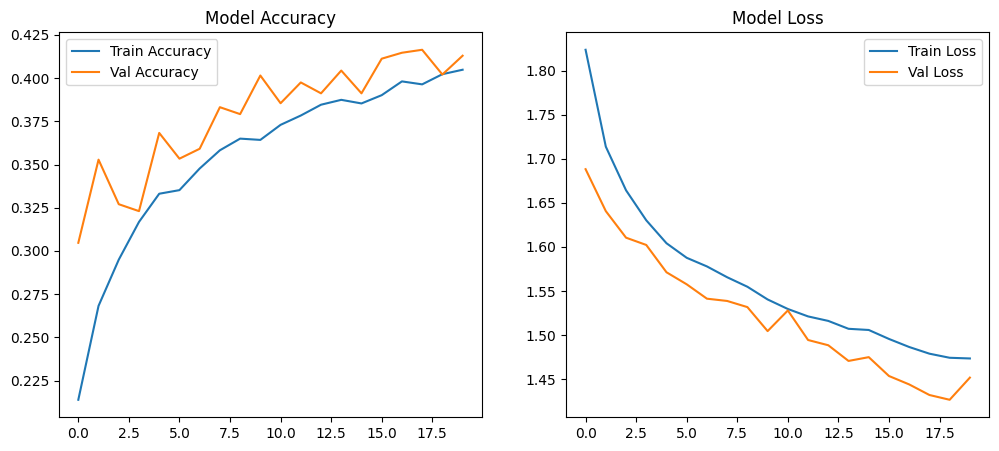

In [24]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


# 2. Restnet101

In [25]:
from tensorflow.keras.applications import ResNet101

resnet_model = ResNet101(weights="imagenet", include_top=False, input_shape=(128, 128, 3))


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [26]:
for layer in resnet_model.layers[-10:]:  
    layer.trainable = True  # Fine-tune only last 10 layers


In [27]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

x = Flatten()(resnet_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=resnet_model.input, outputs=output)

In [28]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy',precision_m, recall_m, f1_m])


In [29]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator)


Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 194s 380ms/step - accuracy: 0.4443 - f1_m: 0.4239 - loss: 1.8304 - precision_m: 0.4930 - recall_m: 0.3735 - val_accuracy: 0.1575 - val_f1_m: 0.1435 - val_loss: 2.8683 - val_precision_m: 0.1792 - val_recall_m: 0.1205
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 54s 206ms/step - accuracy: 0.7302 - f1_m: 0.7217 - loss: 0.7416 - precision_m: 0.7844 - recall_m: 0.6700 - val_accuracy: 0.2033 - val_f1_m: 0.1988 - val_loss: 2.6482 - val_precision_m: 0.2167 - val_recall_m: 0.1841
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 53s 201ms/step - accuracy: 0.8065 - f1_m: 0.8011 - loss: 0.5370 - precision_m: 0.8425 - recall_m: 0.7649 - val_accuracy: 0.3351 - val_f1_m: 0.3356 - val_loss: 3.3571 - val_precision_m: 0.3615 - val_recall_m: 0.3140
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 50s 189ms/step - accuracy: 0.8287 - f1_m: 0.8219 - loss: 0.4962 - precision_m: 0.8572 - recall_m: 0.7906 - val_accuracy: 0.8299 - val_f1_m: 0.8272 - val_loss: 0.4981 - val_precision_m: 0.8401 - 

In [30]:
model.save("/kaggle/working/resnet100.h5")

In [31]:
res100=model.evaluate(test_generator)

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.7574 - f1_m: 0.7580 - loss: 0.8733 - precision_m: 0.7639 - recall_m: 0.7524


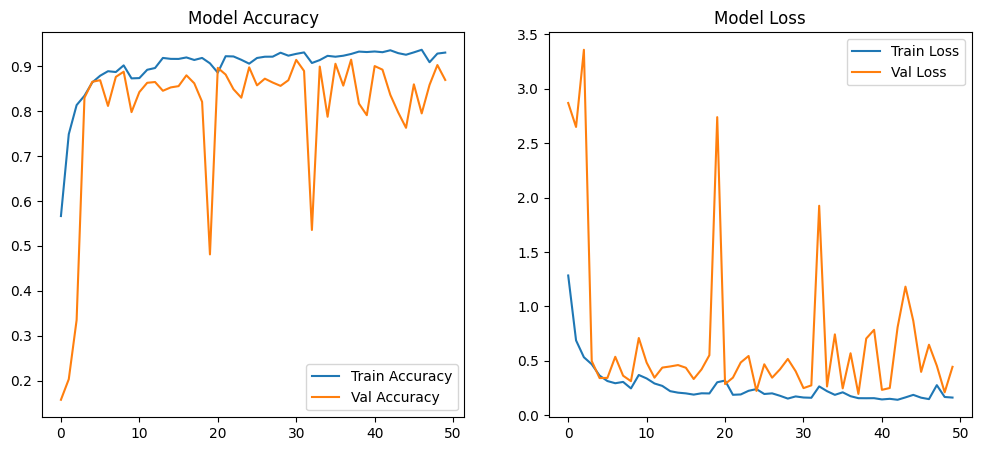

In [32]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


# 3. VGG19

In [33]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load Pretrained VGG19
vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Freeze Initial Layers
for layer in vgg_model.layers[:-5]:  # Fine-tune only last 5 layers
    layer.trainable = False


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
x = Flatten()(vgg_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=output)


In [35]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4),  
              loss='categorical_crossentropy',
              metrics=['accuracy',precision_m, recall_m, f1_m])


In [36]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator)


Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 62s 209ms/step - accuracy: 0.3786 - f1_m: 0.2220 - loss: 1.5259 - precision_m: 0.5009 - recall_m: 0.1569 - val_accuracy: 0.6443 - val_f1_m: 0.6251 - val_loss: 0.9213 - val_precision_m: 0.7135 - val_recall_m: 0.5578
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 176ms/step - accuracy: 0.6526 - f1_m: 0.6248 - loss: 0.8854 - precision_m: 0.7534 - recall_m: 0.5377 - val_accuracy: 0.7297 - val_f1_m: 0.7261 - val_loss: 0.6836 - val_precision_m: 0.7693 - val_recall_m: 0.6884
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 175ms/step - accuracy: 0.7326 - f1_m: 0.7170 - loss: 0.6815 - precision_m: 0.7915 - recall_m: 0.6581 - val_accuracy: 0.7509 - val_f1_m: 0.7470 - val_loss: 0.6661 - val_precision_m: 0.7933 - val_recall_m: 0.7076
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 177ms/step - accuracy: 0.7729 - f1_m: 0.7620 - loss: 0.5855 - precision_m: 0.8133 - recall_m: 0.7185 - val_accuracy: 0.7784 - val_f1_m: 0.7849 - val_loss: 0.5398 - val_precision_m: 0.8114 - v

In [37]:
model.save("/kaggle/working/vgg19.h5")

In [38]:
vgg19=model.evaluate(test_generator)

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.8320 - f1_m: 0.8272 - loss: 0.4242 - precision_m: 0.8398 - recall_m: 0.8155


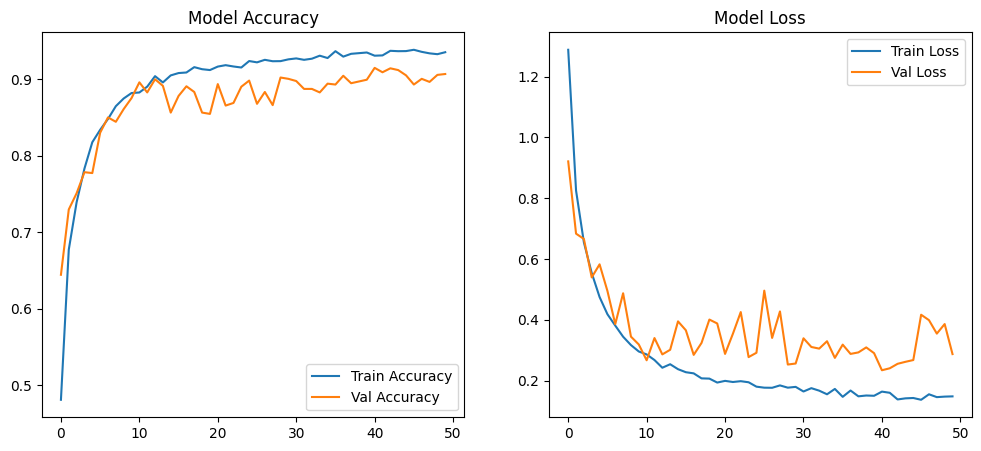

In [39]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


# 4.Inception V3

In [40]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

# Load InceptionV3 model with ImageNet weights (without top layers)
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',precision_m, recall_m, f1_m])

# Summary of the model
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,110 (91.20 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [41]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator)


Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 77s 238ms/step - accuracy: 0.3973 - f1_m: 0.3426 - loss: 2.9140 - precision_m: 0.4822 - recall_m: 0.2832 - val_accuracy: 0.5596 - val_f1_m: 0.5126 - val_loss: 1.1175 - val_precision_m: 0.6783 - val_recall_m: 0.4148
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 44s 170ms/step - accuracy: 0.5253 - f1_m: 0.4360 - loss: 1.2277 - precision_m: 0.6487 - recall_m: 0.3319 - val_accuracy: 0.5813 - val_f1_m: 0.5104 - val_loss: 1.0616 - val_precision_m: 0.7521 - val_recall_m: 0.3908
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 45s 171ms/step - accuracy: 0.5397 - f1_m: 0.4452 - loss: 1.1544 - precision_m: 0.6881 - recall_m: 0.3335 - val_accuracy: 0.5756 - val_f1_m: 0.5291 - val_loss: 1.0600 - val_precision_m: 0.6787 - val_recall_m: 0.4365
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 45s 170ms/step - accuracy: 0.5558 - f1_m: 0.4809 - loss: 1.1388 - precision_m: 0.7024 - recall_m: 0.3704 - val_accuracy: 0.5704 - val_f1_m: 0.5509 - val_loss: 1.0507 - val_precision_m: 0.6918 - v

In [42]:
model.save("/kaggle/working/InceptionV3.h5")

In [43]:
InceptionV3=model.evaluate(test_generator)

55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.6101 - f1_m: 0.5724 - loss: 0.8933 - precision_m: 0.6655 - recall_m: 0.5066


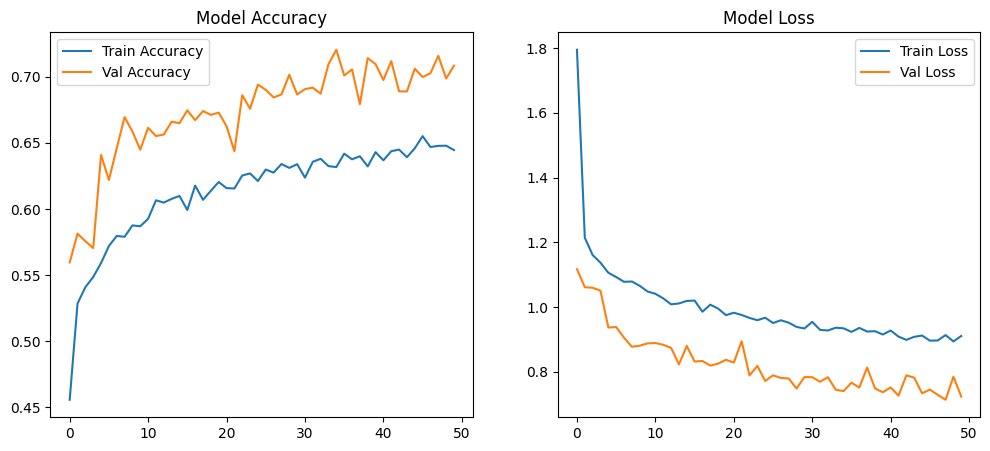

In [44]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


# 5.EfficientNetB3

In [45]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models

# Load EfficientNetB3 with pre-trained ImageNet weights
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Define the model architecture
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',precision_m, recall_m, f1_m])

# Summary of the model
model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 4, 4, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,363,573 (47.16 MB)

 Trainable params: 1,580,038 (6.03 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [46]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator)


Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 105s 286ms/step - accuracy: 0.2140 - f1_m: 0.0126 - loss: 1.8317 - precision_m: 0.0504 - recall_m: 0.0092 - val_accuracy: 0.2182 - val_f1_m: 0.0000e+00 - val_loss: 1.7547 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 174ms/step - accuracy: 0.2244 - f1_m: 0.0000e+00 - loss: 1.7581 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.2457 - val_f1_m: 0.0000e+00 - val_loss: 1.7588 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 178ms/step - accuracy: 0.2034 - f1_m: 0.0000e+00 - loss: 1.7596 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0.2182 - val_f1_m: 0.0000e+00 - val_loss: 1.7530 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 178ms/step - accuracy: 0.2109 - f1_m: 0.0000e+00 - loss: 1.7657 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_accuracy: 0

In [47]:
model.save("/kaggle/working/EfficientNetB3.h5")

In [48]:
EffNetB3=model.evaluate(test_generator)

55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.1512 - f1_m: 0.0000e+00 - loss: 1.8174 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


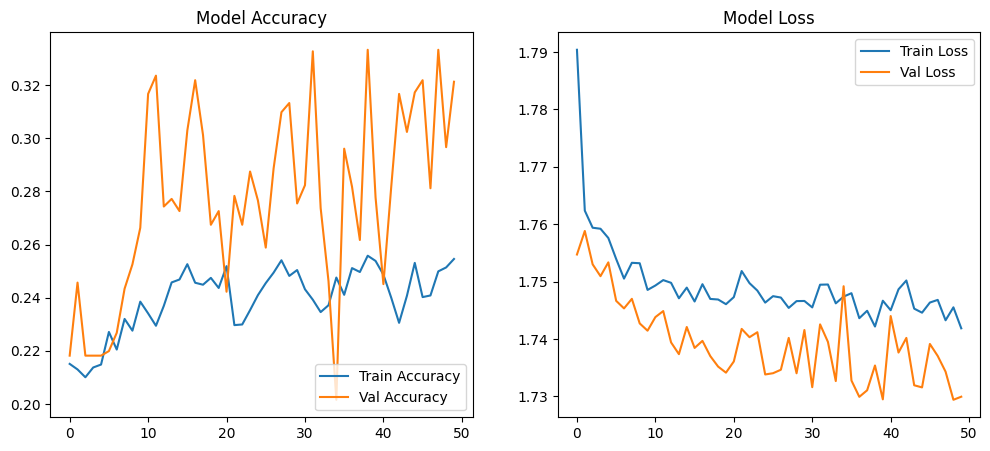

In [49]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


# 6. DenseNet121

In [50]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load DenseNet121 (without top layers)
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(128, 128, 3))  
base_model.trainable = False  # Freeze base model

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(6, activation="softmax")(x)

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy",precision_m, recall_m, f1_m])



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [51]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator)



Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 90s 261ms/step - accuracy: 0.4717 - f1_m: 0.4207 - loss: 1.4776 - precision_m: 0.5749 - recall_m: 0.3360 - val_accuracy: 0.6775 - val_f1_m: 0.6427 - val_loss: 0.8134 - val_precision_m: 0.7787 - val_recall_m: 0.5496
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 45s 172ms/step - accuracy: 0.6081 - f1_m: 0.5752 - loss: 0.9514 - precision_m: 0.7056 - recall_m: 0.4885 - val_accuracy: 0.6861 - val_f1_m: 0.6710 - val_loss: 0.7801 - val_precision_m: 0.7615 - val_recall_m: 0.6018
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 45s 170ms/step - accuracy: 0.6725 - f1_m: 0.6488 - loss: 0.8179 - precision_m: 0.7464 - recall_m: 0.5767 - val_accuracy: 0.6964 - val_f1_m: 0.6930 - val_loss: 0.7401 - val_precision_m: 0.7610 - val_recall_m: 0.6377
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 45s 170ms/step - accuracy: 0.6968 - f1_m: 0.6718 - loss: 0.7654 - precision_m: 0.7585 - recall_m: 0.6053 - val_accuracy: 0.7239 - val_f1_m: 0.7253 - val_loss: 0.6875 - val_precision_m: 0.7836 - v

In [52]:
model.save("/kaggle/working/DenseNet.h5")

In [53]:
DenseNet=model.evaluate(test_generator)

55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.7872 - f1_m: 0.7872 - loss: 0.4925 - precision_m: 0.8046 - recall_m: 0.7715


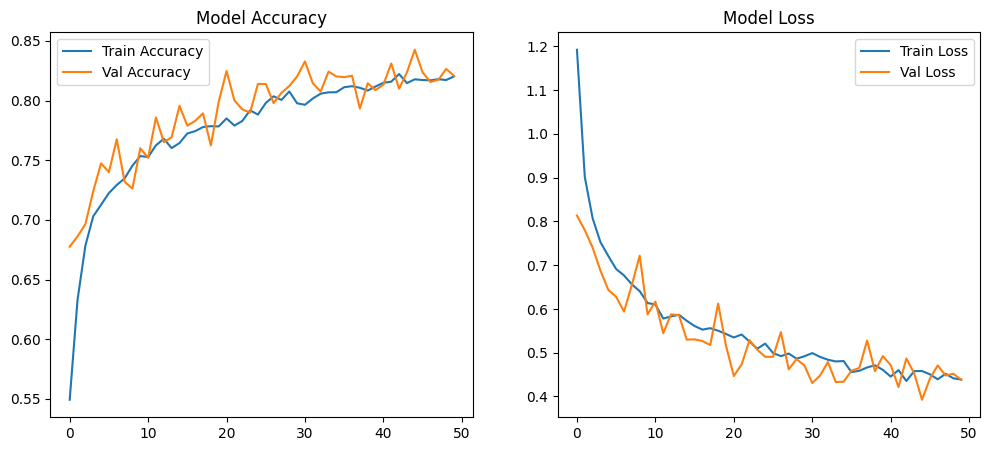

In [54]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


# ****6. VGG19 hypertune****

In [16]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD



# Load Pretrained VGG19
vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Freeze all but last 5 layers
for layer in vgg_model.layers[:-5]:  
    layer.trainable = False

x = Flatten()(vgg_model.output)
x = Dense(512, activation='relu', kernel_regularizer='l2')(x)  # Added L2 regularization
x = Dropout(0.4)(x)  
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=output)

# Compile Model
model.compile(optimizer = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),  
              loss='categorical_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator)



Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.3539 - f1_m: 0.1704 - loss: 14.3467 - precision_m: 0.3797 - recall_m: 0.1183 - val_accuracy: 0.6065 - val_f1_m: 0.5722 - val_loss: 12.8923 - val_precision_m: 0.6963 - val_recall_m: 0.4886
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 175ms/step - accuracy: 0.6061 - f1_m: 0.5673 - loss: 12.4884 - precision_m: 0.7086 - recall_m: 0.4771 - val_accuracy: 0.6793 - val_f1_m: 0.6591 - val_loss: 11.5620 - val_precision_m: 0.7412 - val_recall_m: 0.5961
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 174ms/step - accuracy: 0.7038 - f1_m: 0.6821 - loss: 11.1631 - precision_m: 0.7682 - recall_m: 0.6157 - val_accuracy: 0.7577 - val_f1_m: 0.7458 - val_loss: 10.2839 - val_precision_m: 0.7939 - val_recall_m: 0.7049
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 175ms/step - accuracy: 0.7249 - f1_m: 0.7133 - loss: 10.0806 - precision_m: 0.7793 - recall_m: 0.6593 - val_accuracy: 0.7663 - val_f1_m: 0.7631 - val_loss: 9.3773 - val_precision_m: 0.7

In [18]:
model.save("/kaggle/working/vgg19hypertune.h5")

In [19]:
vgg19ht=model.evaluate(test_generator)

55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 279ms/step - accuracy: 0.8262 - f1_m: 0.8255 - loss: 0.5316 - precision_m: 0.8287 - recall_m: 0.8225


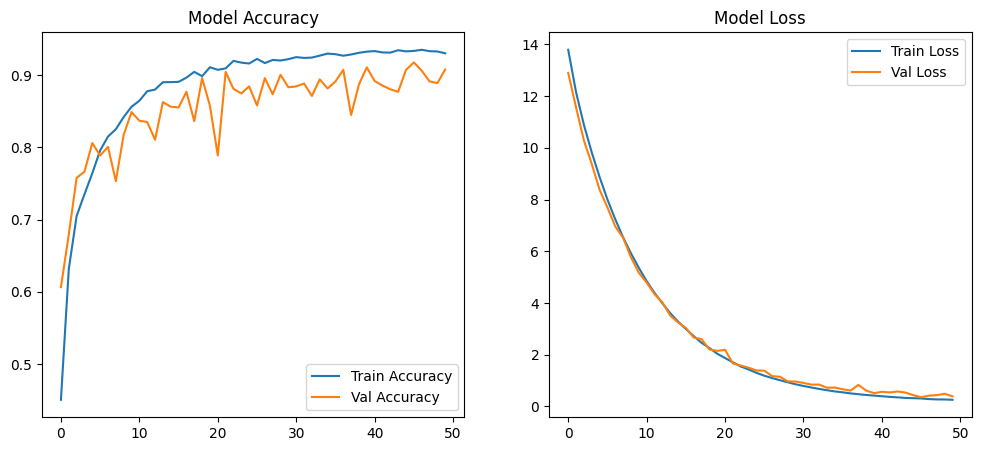

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


# VGG19 hypertune adam


In [24]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Load Pretrained VGG19
vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Freeze all but last 5 layers
for layer in vgg_model.layers[:-10]:  
    layer.trainable = False

x = Flatten()(vgg_model.output)
x = Dense(512, activation='relu', kernel_regularizer='l2')(x)  # Added L2 regularization
x = Dropout(0.4)(x)  
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=output)


# Compile Model
model.compile(optimizer = Adam(learning_rate=5e-5, decay=1e-6),  
              loss='categorical_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])


In [25]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 24,352,070 (92.90 MB)

 Trainable params: 22,026,502 (84.02 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

In [26]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator)



Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 69s 239ms/step - accuracy: 0.3572 - f1_m: 0.2039 - loss: 12.6929 - precision_m: 0.4457 - recall_m: 0.1422 - val_accuracy: 0.6455 - val_f1_m: 0.5915 - val_loss: 8.1592 - val_precision_m: 0.7443 - val_recall_m: 0.4936
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 175ms/step - accuracy: 0.6243 - f1_m: 0.5902 - loss: 7.5082 - precision_m: 0.7295 - recall_m: 0.5015 - val_accuracy: 0.7085 - val_f1_m: 0.6937 - val_loss: 5.7245 - val_precision_m: 0.7466 - val_recall_m: 0.6497
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 177ms/step - accuracy: 0.7103 - f1_m: 0.6914 - loss: 5.3922 - precision_m: 0.7664 - recall_m: 0.6322 - val_accuracy: 0.7194 - val_f1_m: 0.7208 - val_loss: 4.5966 - val_precision_m: 0.7579 - val_recall_m: 0.6881
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 178ms/step - accuracy: 0.7785 - f1_m: 0.7664 - loss: 4.2070 - precision_m: 0.8181 - recall_m: 0.7222 - val_accuracy: 0.7566 - val_f1_m: 0.7605 - val_loss: 3.7495 - val_precision_m: 0.8072 - 

In [27]:
model.save("/kaggle/working/vgg19hypertuneadam.h5")

In [28]:
vgg19ht=model.evaluate(test_generator)

55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.7344 - f1_m: 0.7345 - loss: 0.8029 - precision_m: 0.7400 - recall_m: 0.7292


In [29]:
BS = 64
EPOCHS = 50
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping


base_model = tf.keras.applications.VGG16(input_shape= (128,128,3),include_top=False,weights="imagenet")
base_model.summary()


for layer in base_model.layers[:11]:
    layer.trainable=False


model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(6, activation="softmax"))

model.summary()

# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)


# Run Model
from collections import Counter
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.keras')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_generator,
                  validation_data=val_generator,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)


model.save("/kaggle/working/VGG16tune.h5")

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,883,270 (56.78 MB)

 Trainable params: 13,145,990 (50.15 MB)

 Non-trainable params: 1,737,280 (6.63 MB)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 71s 244ms/step - accuracy: 0.7851 - auc: 0.6114 - f1_score: 0.2113 - loss: 3.7349 - precision: 0.2723 - recall: 0.1741 - val_accuracy: 0.7342 - val_auc: 0.5051 - val_f1_score: 0.2015 - val_loss: 6.3937 - val_precision: 0.2020 - val_recall: 0.2016 - learning_rate: 1.0000e-04
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - accuracy: 0.8153 - auc: 0.7345 - f1_score: 0.3407 - loss: 2.9455 - precision: 0.4210 - recall: 0.2884 - val_accuracy: 0.8041 - val_auc: 0.7768 - val_f1_score: 0.3704 - val_loss: 2.5035 - val_precision: 0.3991 - val_recall: 0.3465 - learning_rate: 1.0000e-04
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 181ms/step - accuracy: 0.8432 - auc: 0.8241 - f1_score: 0.4688 - loss: 2.4024 - precision: 0.5380 - recall: 0.4169 - val_accuracy: 0.8434 - val_auc: 0.8769 - val_f1_score: 0.4963 - val_loss: 1.6757 - val_precision: 0.5346 - val_recall: 0.4645 - learning_rate: 1.0000e-04
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 180ms/step 

In [30]:
model.save("/kaggle/working/vgg16hypertune.h5")

In [31]:
vgg16ht=model.evaluate(test_generator)

55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9511 - auc: 0.9721 - f1_score: 0.8526 - loss: 0.6907 - precision: 0.8564 - recall: 0.8492


NameError: name 'history' is not defined

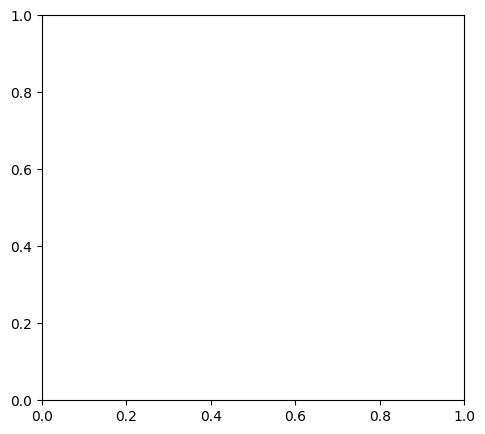

In [1]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()
